# Postprocessing spin

In [47]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast

Import video

In [48]:
video_number = "7"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94018018162597, Total Frames: 332.0


Import data

In [49]:
# Define the path to the CSV file
input_data_path = project_root / "notebook" / "spin" / "intermediate_data" / f"Ball_data_{video_number}.csv"

# Load the CSV file into a DataFrame
ball_df = pd.read_csv(input_data_path)

Postprocessing

In [50]:
# Ensure that both 'rotation_center_x' and 'rotation_center_y' columns exist and have valid values
if 'rotation_center_x' in ball_df.columns and 'rotation_center_y' in ball_df.columns:
    # Drop rows with missing values in the relevant columns
    valid_data = ball_df.dropna(subset=['rotation_center_x', 'rotation_center_y'])
    
    # Compute the distances between consecutive points
    distances = np.sqrt(
        (np.diff(valid_data['rotation_center_x']-valid_data['x']) ** 2) +
        (np.diff(valid_data['rotation_center_y']-valid_data['y']) ** 2)
    )

    relative_x = valid_data['rotation_center_x'] - valid_data['x']
    relative_y = valid_data['rotation_center_y'] - valid_data['y']

    # Add 0 as the first element of distances
    distances = np.insert(distances, 0, 0)

    # Add the distances as a new column to the DataFrame
    valid_data['distance'] = distances
    valid_data['relative_x'] = relative_x
    valid_data['relative_y'] = relative_y

    print(valid_data[['rotation_center_x', 'rotation_center_y', 'distance']])
else:
    print("The required columns 'rotation_center_x' and 'rotation_center_y' are not present in the DataFrame.")

     rotation_center_x  rotation_center_y   distance
91         1181.090159         508.798332   0.000000
92         1186.128570         507.830641  11.192166
93         1191.247611         512.072483  10.279661
94         1195.050117         502.953026   3.316523
95         1195.372610         496.584702   5.367009
..                 ...                ...        ...
207        1395.108038         201.957459  12.071157
208        1400.167229         199.927062   6.774740
211        1407.087427         186.450075  12.305659
212        1390.489223         204.860308  21.312130
220        1413.533366         178.985856  19.043374

[82 rows x 3 columns]


C:\Users\miche\AppData\Local\Temp\ipykernel_17680\2360995570.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['distance'] = distances
C:\Users\miche\AppData\Local\Temp\ipykernel_17680\2360995570.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['relative_x'] = relative_x
C:\Users\miche\AppData\Local\Temp\ipykernel_17680\2360995570.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

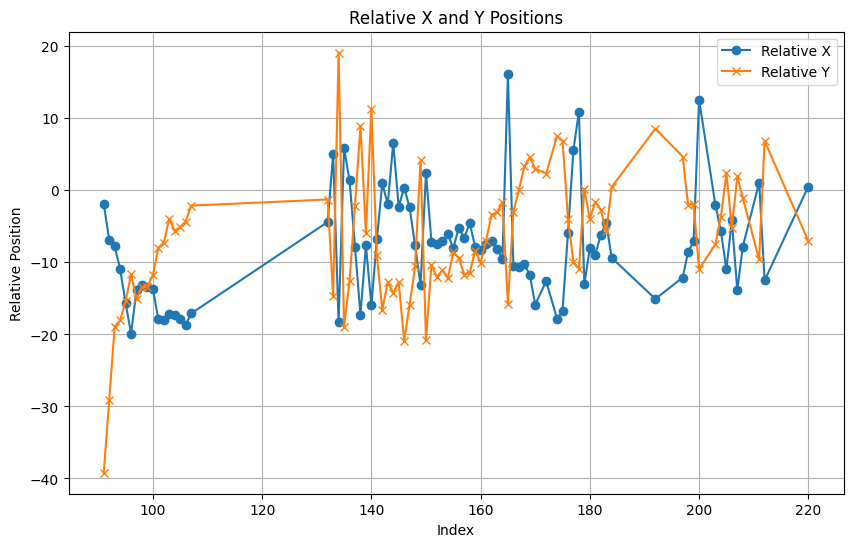

In [51]:
# Plot relative_x and relative_y with respect to the index
plt.figure(figsize=(10, 6))
plt.plot(valid_data.index, valid_data['relative_x'], label='Relative X', marker='o')
plt.plot(valid_data.index, valid_data['relative_y'], label='Relative Y', marker='x')
plt.xlabel('Index')
plt.ylabel('Relative Position')
plt.title('Relative X and Y Positions')
plt.legend()
plt.grid()
plt.show()

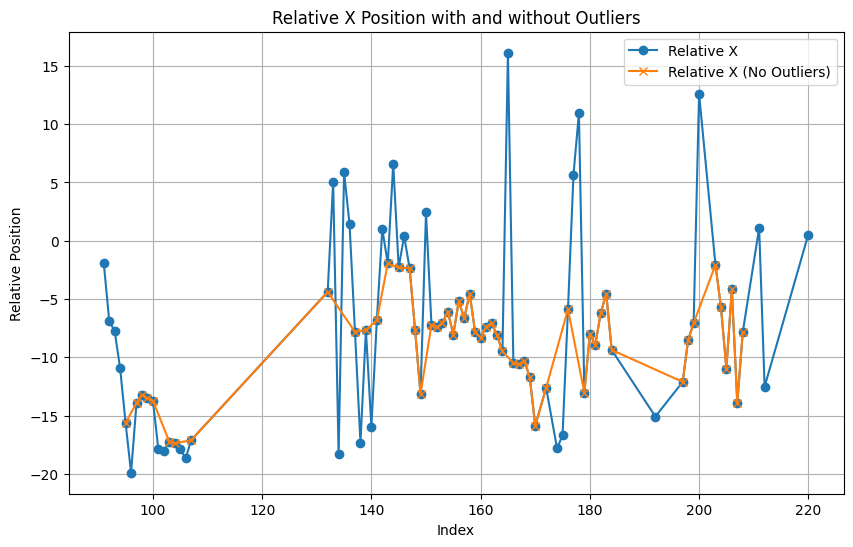

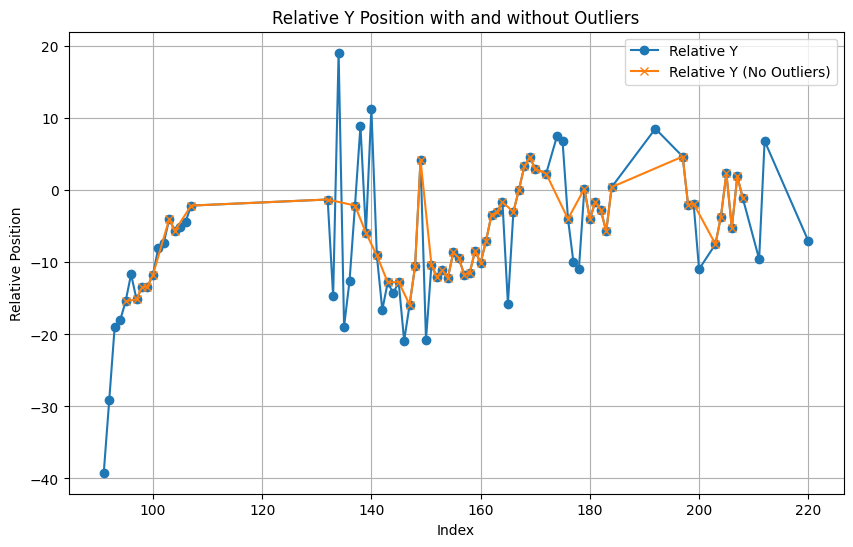

In [52]:
# Define a function to remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 0.5 * IQR
    upper_bound = Q3 + 0.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply outlier removal to 'relative_x' and 'relative_y'
valid_data_no_outliers = remove_outliers_iqr(valid_data, 'relative_x')
valid_data_no_outliers = remove_outliers_iqr(valid_data_no_outliers, 'relative_y')

# Plot the data without outliers for relative_x
plt.figure(figsize=(10, 6))
plt.plot(valid_data.index, valid_data['relative_x'], label='Relative X', marker='o')
plt.plot(valid_data_no_outliers.index, valid_data_no_outliers['relative_x'], label='Relative X (No Outliers)', marker='x')
plt.xlabel('Index')
plt.ylabel('Relative Position')
plt.title('Relative X Position with and without Outliers')
plt.legend()
plt.grid()
plt.show()

# Plot the data without outliers for relative_y
plt.figure(figsize=(10, 6))
plt.plot(valid_data.index, valid_data['relative_y'], label='Relative Y', marker='o')
plt.plot(valid_data_no_outliers.index, valid_data_no_outliers['relative_y'], label='Relative Y (No Outliers)', marker='x')
plt.xlabel('Index')
plt.ylabel('Relative Position')
plt.title('Relative Y Position with and without Outliers')
plt.legend()
plt.grid()
plt.show()

Median filter

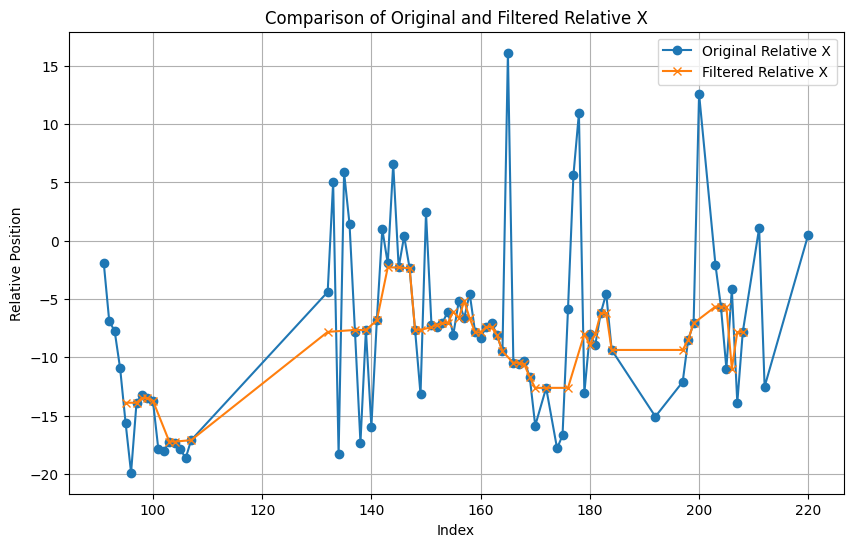

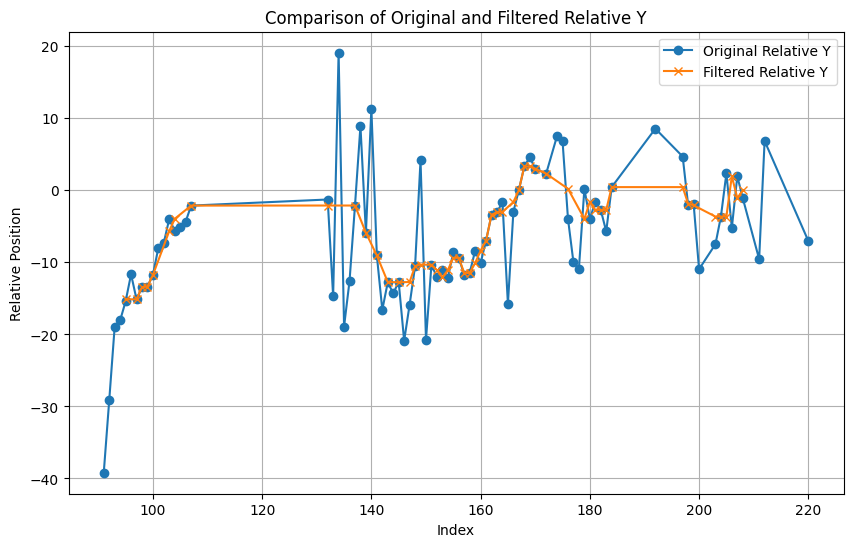

In [53]:
# Apply median filter to 'relative_x' and 'relative_y'
valid_data_no_outliers['filtered_relative_x'] = medfilt(valid_data_no_outliers['relative_x'], kernel_size=3)
valid_data_no_outliers['filtered_relative_y'] = medfilt(valid_data_no_outliers['relative_y'], kernel_size=3)

# Plot the original and filtered data for relative_x
plt.figure(figsize=(10, 6))
plt.plot(valid_data.index, valid_data['relative_x'], label='Original Relative X', marker='o')
plt.plot(valid_data_no_outliers.index, valid_data_no_outliers['filtered_relative_x'], label='Filtered Relative X', marker='x')
plt.xlabel('Index')
plt.ylabel('Relative Position')
plt.title('Comparison of Original and Filtered Relative X')
plt.legend()
plt.grid()
plt.show()

# Plot the original and filtered data for relative_y
plt.figure(figsize=(10, 6))
plt.plot(valid_data.index, valid_data['relative_y'], label='Original Relative Y', marker='o')
plt.plot(valid_data_no_outliers.index, valid_data_no_outliers['filtered_relative_y'], label='Filtered Relative Y', marker='x')
plt.xlabel('Index')
plt.ylabel('Relative Position')
plt.title('Comparison of Original and Filtered Relative Y')
plt.legend()
plt.grid()
plt.show()


Interpolate + smoothing

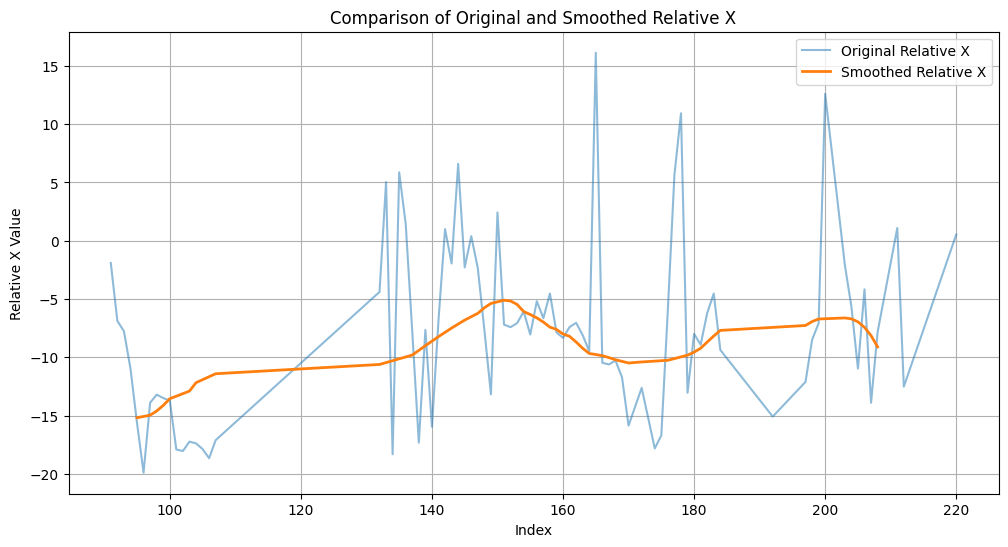

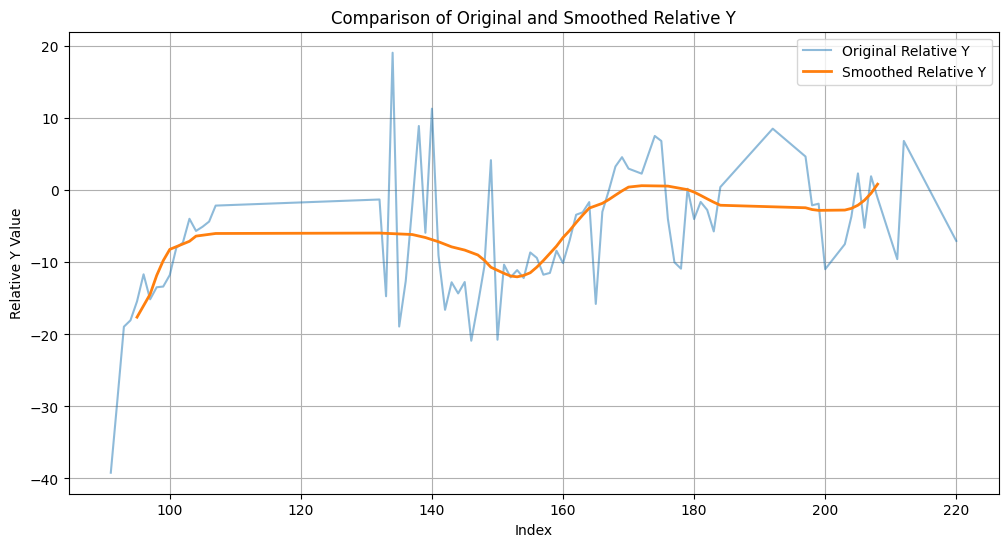

In [54]:
# Interpolate missing values for 'filtered_relative_x' and 'filtered_relative_y'
valid_data_no_outliers['filtered_relative_x'] = valid_data_no_outliers['filtered_relative_x'].interpolate(method='linear')
valid_data_no_outliers['filtered_relative_y'] = valid_data_no_outliers['filtered_relative_y'].interpolate(method='linear')

# Apply Savitzky-Golay filter for smoothing
valid_data_no_outliers['smoothed_filtered_relative_x'] = savgol_filter(valid_data_no_outliers['filtered_relative_x'], window_length=25, polyorder=3)
valid_data_no_outliers['smoothed_filtered_relative_y'] = savgol_filter(valid_data_no_outliers['filtered_relative_y'], window_length=25, polyorder=3)

# Plot valid_data['relative_x'] and valid_data_no_outliers['smoothed_filtered_relative_x']
plt.figure(figsize=(12, 6))
plt.plot(valid_data.index, valid_data['relative_x'], label='Original Relative X', alpha=0.5)
plt.plot(valid_data_no_outliers.index, valid_data_no_outliers['smoothed_filtered_relative_x'], label='Smoothed Relative X', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Relative X Value')
plt.title('Comparison of Original and Smoothed Relative X')
plt.legend()
plt.grid()
plt.show()

# Plot valid_data['relative_y'] and valid_data_no_outliers['smoothed_filtered_relative_y']
plt.figure(figsize=(12, 6))
plt.plot(valid_data.index, valid_data['relative_y'], label='Original Relative Y', alpha=0.5)
plt.plot(valid_data_no_outliers.index, valid_data_no_outliers['smoothed_filtered_relative_y'], label='Smoothed Relative Y', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Relative Y Value')
plt.title('Comparison of Original and Smoothed Relative Y')
plt.legend()
plt.grid()
plt.show()

Convert data

In [55]:
valid_data_no_outliers['rotation_center_x'] = valid_data_no_outliers['smoothed_filtered_relative_x'] + ball_df['x']
valid_data_no_outliers['rotation_center_y'] = valid_data_no_outliers['smoothed_filtered_relative_y'] + ball_df['y']

Generate videos

In [56]:
output_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"spin_video_processed_{video_number}.mp4"

# Ottieni le proprietà del video originale
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Inizializza il VideoWriter
out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

# Riposiziona il video all'inizio
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Itera su tutti i frame del video
frame_idx = 0
while True:
# for i in range(151):
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the current frame index exists in valid_data_filtered
    if frame_idx in valid_data_no_outliers.index:
        # Get the row corresponding to the current frame index
        row = valid_data_no_outliers.loc[frame_idx]

        # Draw the ball center if x and y are not NaN
        if not math.isnan(ball_df.iloc[frame_idx]['x']) and not math.isnan(ball_df.iloc[frame_idx]['y']):
            center = (int(ball_df.iloc[frame_idx]['x']), int(ball_df.iloc[frame_idx]['y']))
            cv2.circle(frame, center, 5, (255, 0, 0), -1) 

        # Draw the rotation center if rotation_center_x and rotation_center_y are not NaN
        if not math.isnan(row['rotation_center_x']) and not math.isnan(row['rotation_center_y']):
            rotation_center = (int(row['rotation_center_x']), int(row['rotation_center_y']))
            cv2.circle(frame, rotation_center, 5, (0, 255, 255), -1)  

    # Scrivi il frame nel video di output
    out.write(frame)

    # Incrementa l'indice del frame
    frame_idx += 1

# Rilascia le risorse
out.release()

print(f"Video annotato salvato in: {output_video_path}")

Video annotato salvato in: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_7\test_video\spin_video_processed_7.mp4


Cropped video

In [57]:
# Define the output path for the cropped video
cropped_ball_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"spin_video_ball_cropped_{video_number}.mp4"

crop_size = 80

# Initialize the VideoWriter for the cropped video
cropped_ball_out = cv2.VideoWriter(str(cropped_ball_video_path), fourcc, fps, (2 * crop_size, 2 * crop_size))

# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Iterate through all frames of the video
frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the current frame index exists in ball_df
    if frame_idx in valid_data_no_outliers.index:
        # Get the row corresponding to the current frame index
        row = ball_df.iloc[frame_idx]

        # Ensure the ball center coordinates and radius are valid
        if not math.isnan(row['x']) and not math.isnan(row['y']) and not math.isnan(row['radius']):
            center_x = int(row['x'])
            center_y = int(row['y'])
            radius = crop_size

            # Define the cropping region
            x_start = max(center_x - radius, 0)
            y_start = max(center_y - radius, 0)
            x_end = min(center_x + radius, frame_width)
            y_end = min(center_y + radius, frame_height)

            # Crop the frame
            cropped_frame = frame[y_start:y_end, x_start:x_end]
            # Draw the ball center if x and y are not NaN
            cv2.circle(cropped_frame, (crop_size, crop_size), 5, (255, 0, 0), -1)

            # Draw the rotation center if rotation_center_x and rotation_center_y are not NaN
            if not math.isnan(valid_data_no_outliers.loc[frame_idx]['rotation_center_x']) and not math.isnan(valid_data_no_outliers.loc[frame_idx]['rotation_center_y']):
                rotation_center_x = int(valid_data_no_outliers.loc[frame_idx]['rotation_center_x']) - x_start
                rotation_center_y = int(valid_data_no_outliers.loc[frame_idx]['rotation_center_y']) - y_start
                if 0 <= rotation_center_x < cropped_frame.shape[1] and 0 <= rotation_center_y < cropped_frame.shape[0]:
                    cv2.circle(cropped_frame, (rotation_center_x, rotation_center_y), 5, (0, 255, 255), -1)
            # Write the cropped frame to the output video
            cropped_ball_out.write(cropped_frame)

    # Increment the frame index
    frame_idx += 1

# Release resources
cropped_ball_out.release()

print(f"Cropped ball video saved at: {cropped_ball_video_path}")


Cropped ball video saved at: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_7\test_video\spin_video_ball_cropped_7.mp4
